# Feature Engineering

This notebook create new features and mesures the the perfomance change in the model. The goal is to create features to increase the model performance.

In [48]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Import the data

In [49]:
# Read the data to a pandas data frame
df_apartments = pd.read_csv('original_apartment_data_analytics_hs24_with_lat_lon.csv', sep=',', encoding='utf-8')
df_taxvalues = pd.read_csv('bfs_tax_values_data.csv', sep=',', encoding='utf-8')
df = pd.merge(df_apartments, df_taxvalues.drop(columns=['bfs_name']), on='bfs_number', how='inner')
# Get number of rows and columns
df.shape
print(df.head())

   bfs_number  rooms  area  price  postalcode  \
0         118    3.0    49   1441        8630   
1         118    3.0   111   2600        8630   
2         118    3.0    58   1490        8630   
3         118    4.0   118   3240        8630   
4         118    3.0    66   1450        8630   

                            address      town  \
0     Neuhusstrasse 6, 8630 Rüti ZH   Rüti ZH   
1   Widacherstrasse 5, 8630 Rüti ZH   Rüti ZH   
2         Widenweg 14, 8630 Rüti ZH   Rüti ZH   
3              Rain 1, 8630 Rüti ZH   Rüti ZH   
4  Bachtelstrasse 24b, 8630 Rüti ZH   Rüti ZH   

                                     description_raw   bfs_name    pop  ...  \
0                     «Gemütliche Wohnung im Grünen»  Rüti (ZH)  12286  ...   
1                      «3 Zimmer-Maisonette-Wohnung»  Rüti (ZH)  12286  ...   
2            «Ruhig & Grün , Genau was Sie suchen !»  Rüti (ZH)  12286  ...   
3  «Gemütliches 4-Zimmer-Reihenhaus in zentraler ...  Rüti (ZH)  12286  ...   
4       «Schöne

In [50]:
df.columns

Index(['bfs_number', 'rooms', 'area', 'price', 'postalcode', 'address', 'town',
       'description_raw', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income', 'lat', 'lon', 'x', 'y', 'canton', 'tax_canton',
       'tax_municipality', 'tax_church_ref', 'tax_church_römkat',
       'tax_church_christkt'],
      dtype='object')

## Model Performance

In [51]:
def model_performance(features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df = df.sample(frac=1, random_state=42)
    X, y = df[features], df['price']
    scores = cross_val_score(random_forest_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

In [52]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)

CV results RMSE: [ -758.  -817.  -891. -1112.  -871.]
Mean RMSE: -889.8


## Data Cleaning
- Remove apartments with empty columns
- Remove apartments which price exceeds 6000.-
- Remove apartments which price is lower than 1000.-

In [53]:
print('Total apartment before data cleaning:', len(df))

# Remove missing values
df = df.dropna()

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 750) & 
            (df['price'] <= 8000)]

print('Total apartment after data cleaning:', len(df))

Total apartment before data cleaning: 816
Total apartment after data cleaning: 801


In [54]:
# Before data cleaning Mean RMSE: -894.8

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)

CV results RMSE: [-667. -745. -687. -678. -743.]
Mean RMSE: -704.0


## Feature engineering

### Create additional variables from the apartment's descriptions

In [55]:
df['mean_tax'] = round(df['tax_canton'] + df['tax_municipality'] + ((df['tax_church_christkt'] + df['tax_church_ref'] + df['tax_church_römkat']) / 4), 2)

In [56]:
# Use the new variable
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'mean_tax']
model_performance(features, df)

CV results RMSE: [-666. -745. -683. -672. -745.]
Mean RMSE: -702.2


In [57]:
df.to_csv('apartments_data_enriched_with_new_features.csv')

## Weiteres

<Axes: ylabel='features'>

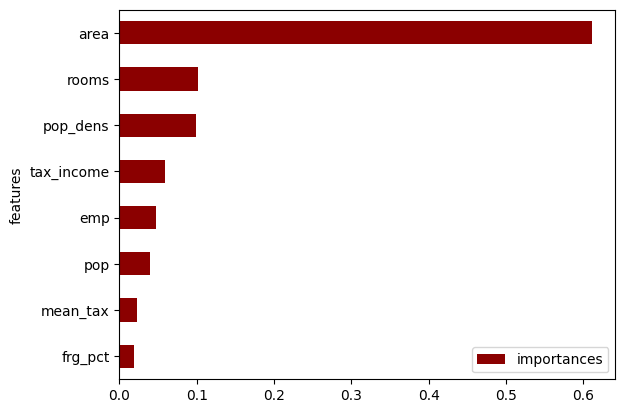

In [58]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

In [72]:
# Read the data to a pandas data frame
df_municipality = pd.read_csv('bfs_municipality_and_tax_data.csv', sep=',', encoding='utf-8')
df_taxvalues = pd.read_csv('bfs_tax_values_data.csv', sep=',', encoding='utf-8')
df2 = pd.merge(df_municipality, df_taxvalues.drop(columns=['bfs_name']), on='bfs_number', how='inner')
df2['mean_tax'] = round(df2['tax_canton'] + df2['tax_municipality'] + ((df2['tax_church_christkt'] + df2['tax_church_ref'] + df2['tax_church_römkat']) / 4), 2)
df2.drop(columns=['canton', 'tax_canton', 'tax_municipality', 'tax_church_christkt', 'tax_church_ref', 'tax_church_römkat'], inplace=True)
# Get number of rows and columns
df2.shape
print(df2.head())

df2.to_csv('bfs_all_tax_data.csv')

   bfs_number            bfs_name    pop     pop_dens    frg_pct     emp  \
0           1     Aeugst am Albis   1981   250.442478  14.184755   442.0   
1           2  Affoltern am Albis  12303  1161.756374  28.700317  6920.0   
2           3          Bonstetten   5572   749.932705  16.564968  1014.0   
3           4     Hausen am Albis   3751   275.808824  16.022394  1021.0   
4           5            Hedingen   3778   578.560490  16.410799  1478.0   

  tax_income  mean_tax  
0    108'788    199.75  
1     72'583    231.75  
2     91'002    217.25  
3     91'766    220.00  
4     94'456    207.75  
